In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
## ROI pooled embeddings (7x7x256)

In [2]:
embed_classwise = {}
fea_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_features/gt/pooled/"

In [3]:
for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1

In [4]:
# Extract embeddings and corresponding class labels
all_embeddings = []
class_labels = []
for class_label, embeddings in embed_classwise.items():
    all_embeddings.extend(embeddings)
    class_labels.extend([class_label] * len(embeddings))

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
class_labels = np.array(class_labels)
num_sample = class_labels.shape[0]
all_embeddings = all_embeddings.reshape(num_sample,-1)

del embed_classwise

In [7]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=1024)  # Adjust the number of components as needed
pca_embeddings = pca.fit_transform(all_embeddings)

# Compute t-SNE embeddings on PCA embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [6]:
all_embeddings.shape,class_labels.shape

((77051, 12544), (77051,))

In [ ]:
em

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
unique_labels = np.unique(class_labels)
for label in unique_labels:
    indices = np.where(class_labels == label)
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], label=label)

plt.title('t-SNE Plot of Class Clusters (After PCA)')
plt.legend([
                        "bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"
                          ])
plt.show()

In [ ]:
# Perform PCA for dimensionality reduction
#pca = PCA(n_components=50)  # Adjust the number of components as needed
#pca_embeddings = pca.fit_transform(all_embeddings)

# Compute t-SNE embeddings on PCA embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(all_embeddings)

## Train linear SVM to as measure of seperability

In [9]:
from sklearn import svm

In [10]:
clf = svm.LinearSVC()
clf.fit(all_embeddings, class_labels)

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [12]:
y_pred = clf.predict(all_embeddings)
y = class_labels

# Calculate and display training metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Training Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Training Metrics:
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-score: 0.99


## Qualitative testing on OOD samples

In [1]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import cv2
from detectron2.data.datasets import register_coco_instances

In [ ]:
#register dataset
def register_esmart_wip(root = "/home/vaibhav/Desktop/stud/datasets/esmart/"):
        things_classes = [str(i) for i in range(600)]
        name = 'esmart_wip_mod'
        metadata = {"thing_classes":things_classes}
        register_coco_instances(
                        name,
                        metadata,
                        os.path.join(root, 'labels_mod.json'),
                        os.path.join(root, 'data/'),
                    )

register_esmart_wip()

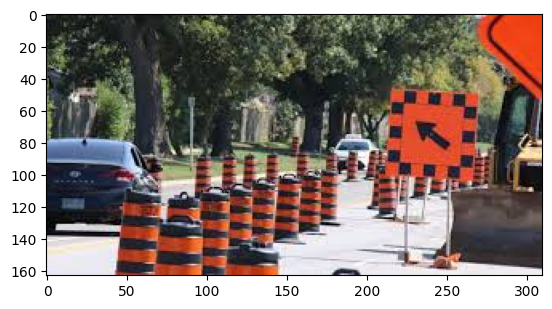

In [6]:
im = cv2.imread("/home/vaibhav/Desktop/stud/datasets/esmart/test/3.jpeg")
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [3]:
#cfg = get_cfg()
#cfg.merge_from_file("/home/vaibhav/Desktop/ood_distance/finetune_coco_trained.yaml")
# Create predictor
#cfg.MODEL.WEIGHTS = "/home/vaibhav/Desktop/ood_distance/checkpoints/esmart/coco_finetune_on_esmart/model_final.pt#h"
cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=True)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 600
cfg.DATASETS.TRAIN = ('esmart_wip_mod',)
cfg.MODEL.WEIGHTS = "/home/vaibhav/Desktop/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST: 0.7
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

/home/vaibhav/Desktop/detectron2/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/vaibhav/Desktop/detectron2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


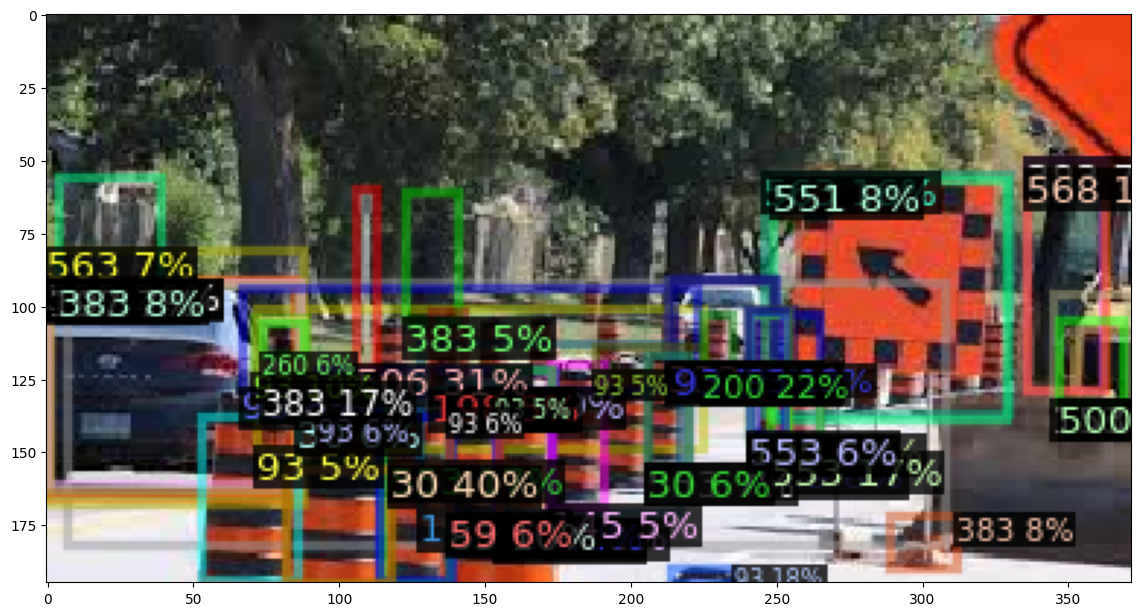

In [7]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
